# 一、摩根分子指纹计算
## 1.简介
摩根分子指纹（Morgan Fingerprints），是一种圆形指纹，也属于拓扑型指纹，是通过对标准的摩根算法进行改造后得到。可以大致等同于扩展连通性指纹（Extended-Connectivity Fingerprints，ECFPs）。

这类指纹有诸多优点，例如计算速度快、没有经过预定义（可以表示无穷多种不同的分子特征）、可以包含手性信息、指纹中的每个元素代表一种特定子结构、可以方便地进行分析和解释、可以根据不同的需要进行相应的修改等。这类指纹设计的最初目的是用于搜索与活性相关的分子特征，而非子结构搜索。此外也可以用于相似性搜索、聚类、虚拟筛选等方向。指纹的生成过程大致分为以下几个步骤：
 - 原子初始化。为每个重原子分配一个整数标识符
 - 迭代更新。以每个重原子为中心，将周围一圈的重原子合并进来，直到到达指定半径。
 - 特征生成。对子结构进行运算，并生成特征列表。
 
更多内容可以[参考ChemAxon的介绍](https://blog.csdn.net/dreadlesss/article/details/105590719)，还有[ECFPs的文章](http://pubs.acs.org/doi/abs/10.1021/ci100050t)。

ECFPs可以捕捉到精确的子结构细节，相对应的，功能基指纹（Functional class fingerprints，FCFPs）则更为泛化，可以将同一类功能基作为一种特征结构。在rdkit中两种特征都可以通过GetMorganFingerprint实现。

* 初始化

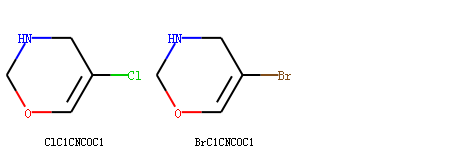

In [1]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
m1 = Chem.MolFromSmiles('ClC1=COCNC1')
m2 = Chem.MolFromSmiles('BrC1=COCNC1')
img = Draw.MolsToGridImage([m1, m2], subImgSize=(150, 150), legends=['ClC1CNCOC1', 'BrC1CNCOC1'])
img

In [2]:
img.save('data/morgan_sample.png')

## 2.SparseIntVects
* 以SparseIntVects方式生成ECFPs指纹：GetMorganFingerprint(mol, radius, ...)<br />
或者称为SparseBitVects<br />
mol：mol对象<br />
radius：考虑半径

In [3]:
fp1 = AllChem.GetMorganFingerprint(m1, 2)
fp2 = AllChem.GetMorganFingerprint(m2, 2)
DataStructs.DiceSimilarity(fp1, fp2)

0.7

* 查看长度：GetLength()<br />
返回指纹的长度
* 查看非空元素：GetNonzeroElements()<br />
返回值是一个字典，键对应非空指纹的位数，值是指纹出现的频数

In [4]:
print(fp1.GetLength())
print(fp1.GetNonzeroElements())

4294967295
{39328034: 1, 211414882: 1, 362715007: 1, 397705891: 1, 718785834: 1, 1016841875: 1, 1078999752: 1, 1289643292: 1, 2132511834: 1, 2626911012: 1, 2968968094: 2, 3145053355: 1, 3189457552: 1, 3217380708: 1, 3218693969: 1, 3452535345: 1, 3916672621: 1, 4196496269: 1, 4217154750: 1}


## 3.ExplicitBitVects
* 以ExplicitBitVects方式生成ECFPs指纹：GetMorganFingerprintAsBitVect(mol, radius, nBits, ...)<br />
radius：考虑半径<br />
nBits：长度

In [5]:
fp1 = AllChem.GetMorganFingerprintAsBitVect(m1, 2, nBits=1024)
fp2 = AllChem.GetMorganFingerprintAsBitVect(m2, 2, nBits=1024)
DataStructs.DiceSimilarity(fp1, fp2)

0.6842105263157895

## 4.FCFPs
* 通过设置useFeatures=True生成FCFPs <br /> 
可以看到ffp1和ffp2完全一致，即Cl和Br在特征上被归为一类

In [6]:
ffp1 = AllChem.GetMorganFingerprint(m1, 2, useFeatures=True)
ffp2 = AllChem.GetMorganFingerprint(m2, 2, useFeatures=True)
DataStructs.DiceSimilarity(ffp1, ffp2)

1.0

In [7]:
ffp1 = AllChem.GetMorganFingerprintAsBitVect(m1, 2, nBits=10, useFeatures=True)
ffp2 = AllChem.GetMorganFingerprintAsBitVect(m2, 2, nBits=10, useFeatures=True)
DataStructs.DiceSimilarity(ffp1, ffp2)

1.0

* 查看向量长度：GetNumBits()
* 将指纹转成字符串：ToBitString()

In [8]:
print(ffp1.GetNumBits())
print(ffp1.ToBitString())

10
1111101111


## 5.更多泛化
* 通过设置invariants，忽略原子类型，关注分子骨架

In [9]:
m2 = Chem.MolFromSmiles('BrC1=CCCCC1')
m3 = Chem.MolFromSmiles('BrC1CCCCC1')
Draw.MolsToGridImage([m1, m2, m3], subImgSize=(200, 150))
fp1 = AllChem.GetMorganFingerprint(m1, 2, invariants=[1]*m1.GetNumAtoms())
fp2 = AllChem.GetMorganFingerprint(m2, 2, invariants=[1]*m2.GetNumAtoms())
fp3 = AllChem.GetMorganFingerprint(m3, 2, invariants=[1]*m3.GetNumAtoms())
fp1 == fp2

True

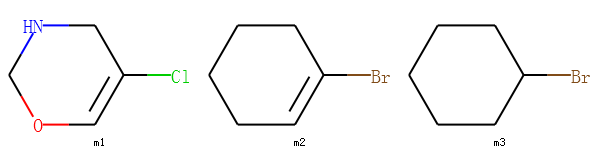

In [10]:
img = Draw.MolsToGridImage([m1, m2, m3], subImgSize=(200, 150), legends=['m1', 'm2', 'm3'])
img

In [11]:
img.save('data/morgan_sample2.png')

* 可以看到指纹忽略了N和C的差异，fp1和fp2指纹一致，但这个时候还会考虑键的信息。例如比较fp1和fp3，它们是不相等的。

In [12]:
fp1 == fp3

False

* 通过设置useBondTypes，忽略键的类型

In [13]:
fp1 = AllChem.GetMorganFingerprint(m1, 2, invariants=[1]*m1.GetNumAtoms(), useBondTypes=False)
fp3 = AllChem.GetMorganFingerprint(m1, 2, invariants=[1]*m3.GetNumAtoms(), useBondTypes=False)
fp1 == fp3

True

# 二、摩根分子指纹提取
* 在生成分子指纹过程中，通过向参数bitInfo传入字典，可以获取所有非空指纹信息 <br /> 
字典info键表示位的索引，值为原子索引、半径构成的元组，出现多个元组时，表示子结构出现了多次<br />
键为2968968094的值中含有多个元组，表示原子索引为4,6，半径为0的子结构相同，都记录在这一位上

In [14]:
info = {}
fp_explain = AllChem.GetMorganFingerprint(m1, 2, bitInfo=info)
info

{39328034: ((1, 1),),
 211414882: ((5, 2),),
 362715007: ((6, 1),),
 397705891: ((4, 1),),
 718785834: ((1, 2),),
 1016841875: ((0, 0),),
 1078999752: ((3, 1),),
 1289643292: ((5, 1),),
 2132511834: ((5, 0),),
 2626911012: ((4, 2),),
 2968968094: ((4, 0), (6, 0)),
 3145053355: ((2, 1),),
 3189457552: ((3, 0),),
 3217380708: ((1, 0),),
 3218693969: ((2, 0),),
 3452535345: ((0, 1),),
 3916672621: ((6, 2),),
 4196496269: ((2, 2),),
 4217154750: ((3, 2),)}

## 1.方法一
* 以提取出211414882的结构为例，首先提取m1中，半径为2，第5个原子的结构 <br />
submol接收提取出的子结构 <br />
amap用于接收原子索引的映射关系，键为原始分子中的原子索引，值为子结构中的原子索引<br />
env是被提取出的键的索引

In [15]:
amap = {}
env = Chem.FindAtomEnvironmentOfRadiusN(m1, 2, 5)
submol=Chem.PathToSubmol(m1, env, atomMap=amap)
print(amap)
print(list(env))

{1: 4, 3: 0, 4: 1, 5: 2, 6: 3}
[4, 5, 3, 6]


* 用SMILES表示该子结构

In [16]:
Chem.MolToSmiles(submol)

'CCNCO'

* 以第5个原子为中心，用SMILES表示该子结构，可以看出是氮原子

In [17]:
Chem.MolToSmiles(submol, rootedAtAtom=amap[5], canonical=False)

'N(CO)CC'

## 2.方法二
* 遍历env中的所有键，获取键连接的所有原子，保存在atoms中 <br />
通过给定分子，及要提取的原子信息、键信息，获取子结构

In [18]:
atoms=set()
for bidx in env: 
    atoms.add(m1.GetBondWithIdx(bidx).GetBeginAtomIdx())
    atoms.add(m1.GetBondWithIdx(bidx).GetEndAtomIdx())
Chem.MolFragmentToSmiles(m1, atomsToUse=list(atoms), bondsToUse=env, rootedAtAtom=5)

'N(CC)CO'

# 三、指纹可视化
查看211414882代表的子结构
* 绘制子结构：DrawMorganBit(mol, bitId, bitInfo, ...)<br />
mol：mol对象<br />
bitId：要查看的bit id<br />
bitInfo：指纹信息

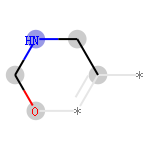

In [19]:
img = Draw.DrawMorganBit(m1, 211414882, info)
img

In [20]:
img.save('data/morgan_vis1.png')

* 在ECFPs中的颜色的含义：<br />
蓝色：表示中心原子<br />
黄色：表示带有芳香性质的原子<br />
灰色：表示在脂肪环中的原子

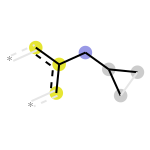

In [21]:
mol = Chem.MolFromSmiles('c1ccccc1CC1CC1')
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
img = Draw.DrawMorganBit(mol, 872, bi)
img

In [22]:
img.save('data/morgan_vis2.png')